# Preliminary EDA | Float, Satellite, and Merged Datasets
- Location maps and heatmaps
- Feature, spatial, and temporal distribution analysis
- Missing values

Josie Donnelly

*Last updated 12.16.22*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import Normalize, LogNorm


## define flexible plotting functions

In [2]:
# function to plot satellite or float data over global map
def plot_on_map(df, source, features=None, data_type=None, figsize=(10,4), subtitle=None):
    '''
    function to plot latitude and longitude of (float or satellite) data over the world map, colored by zero or more features
    
    arguments
    ---------
    df (pandas df):
        dataframe, already filtered as desired
    source (str):
            satellite, float, or a matchup; used in the plot titles
    features (str or list-like or None):
              string of a single feature, or list of strings of features corresponding to column names of df;
              there will be a different plot for every feature;
              if features is None, just latitude and longitude will be plotted with no coloring by feature;
              list of features may include None
    data_type (str or list-like or None):
               single or list containing 'continuous', 'discrete' or 'categorical', or None to determine use of colorbar, legend, or no color respectively ;
               if a single value, then it is assumed to be applied to all features;
               if a list, then it it must have the same length as the list of features
    figsize (tuple):
             figsize argument passed to plt.figure()
    subtitle (str or None):
              optional additional line to add to the title; a single string that will be applied to all plots
    '''
    
    # argument modifications
    if type(features) == str:
        features = [features]
        
    if features is None:
        features = [None]
        
    if data_type == 'discrete':
        data_type = 'categorical'
    
    if type(data_type) == list:
        data_type = ['categorical' if t=='discrete' else t for t in data_type]
        
    if type(data_type) == list and len(features) != len(data_type):
        print('Error — len(features) and len(data_type) should be equal')
        return
    
    if subtitle is not None and subtitle.strip() == '':
        subtitle = None
        
    # obtain map
    land = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    
    for f in features:
        
        # plot the base map
        land.plot(color='lightgray', figsize=figsize)
        
        # scatter plot with no color if feature is None
        if f is None:
            plt.scatter(df['longitude'], df['latitude'], s=1, alpha=0.5)
            if subtitle is None:
                plt.title(f'Latitude vs. Longitude for {source.title()} Data', fontsize='x-large')
            else:
                plt.title(f'Latitude vs. Longitude for {source.title()} Data\n({subtitle})', fontsize='x-large')
            
        else:
            f_df = df[df[f].notna()].reset_index(drop=True)

            # scatter plot, colored by continuous feature
            if data_type == 'continuous' or (type(data_type) == list and data_type[features.index(f)] == 'continuous'):
                plt.scatter(f_df['longitude'], f_df['latitude'], c=f_df[f], cmap='plasma_r', s=1, alpha=0.5)
                cbar = plt.colorbar(label=f)
                cbar.ax.invert_yaxis()

            # scatter plot, colored by categorical feature
            elif data_type == 'categorical' or (type(data_type) == list and data_type[features.index(f)] == 'categorical'):
                colors = [list(np.unique(f_df[f])).index(v) for v in f_df[f]]
                color_indices = np.unique(colors, return_index=True)[1]
                labels = [f_df.loc[i,f] for i in sorted(color_indices)]
                scatter = plt.scatter(f_df['longitude'], f_df['latitude'], c=colors, cmap='plasma_r', s=1, alpha=0.5)
                plt.legend(handles=scatter.legend_elements()[0], labels=labels, title=f, loc='upper left', bbox_to_anchor=(1,1))

            if subtitle is None:
                plt.title(f'{source.title()} Data Latitude vs. Longitude\nColored by {f.title()}', fontsize='x-large')
            else:
                plt.title(f'{source.title()} Data Latitude vs. Longitude\nColored by {f.title()}\n({subtitle})', fontsize='x-large')
            
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        
        # display plot
        plt.show()


In [3]:
# function to plot heatmap by latitude and longitude over global map
def plot_loc_heatmap(df, source, agg_funct='mean', features=None, figsize=(10,4), subtitle=None, cmap='viridis'):

    '''
    function to plot a heat map over the world map, colored by zero or more features
    
    arguments
    ---------
    df (pandas df):
        dataframe, already filtered as desired
    source (str):
            satellite, float, or a matchup; used in the plot titles
    agg_funct (string):
               the aggregate function applied to compute values for heat map (i.e., 'mean', 'sum', or 'std');
               only mean and sum are implemented as of now;
               choice will be applied to all features that are not None;
               agg_funct disregarded if features is None
    features (str or list-like or None):
              string of a single feature, or list of strings of features corresponding to column names of df;
              there will be a different plot for every feature;
              if features is None, just latitude and longitude will be plotted with no coloring by feature;
              list of features may include None
    data_type (str or list-like or None):
               single or list containing 'continuous', 'discrete' or 'categorical', or None to determine use of colorbar, legend, or no color respectively ;
               if a single value, then it is assumed to be applied to all features;
               if a list, then it it must have the same length as the list of features
    figsize (tuple):
             figsize argument passed to plt.figure()
    subtitle (str or None):
              optional additional line to add to the title; a single string that will be applied to all plots
    '''
    
    # argument modifications    
    agg_funct = agg_funct.lower()
    if features is not None and agg_funct not in ['mean', 'sum', 'std', 'count']:
        print(f"Error — use agg_funct = 'mean', 'sum', 'std', or 'count'; or, implement agg_funct for {agg_funct}")
        print("Proceeding using agg_funct = 'mean'")
    
    if type(features) == str:
        features = [features]
        
    if features is None:
        features = [None]

    if subtitle is None:
        subtitle = ''
        
    if subtitle.strip() != '':
        subtitle = f'\n({subtitle})'
        
    # obtain map
    land = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
        
    for f in features:
        
        # initialize matrix of pixel values
        vals = np.zeros(shape=(180, 360))

        # obtain measurements by location
        for lat_idx in range(vals.shape[0]):
            lat = 90 - lat_idx
            lat_df = df[(df['latitude'] >= lat - 0.5) & (df['latitude'] < lat + 0.5)]

            for long_idx in range(vals.shape[1]):
                long = long_idx - 180
                lat_long_df = lat_df[(lat_df['longitude'] >= long - 0.5) & (lat_df['longitude'] < long + 0.5)]

                if f is not None:
                    lat_long_df = lat_long_df[lat_long_df[f].notna()].reset_index(drop=True)
                
                if lat_long_df.shape[0] == 0:
                    vals[lat_idx,long_idx] = np.nan
                    continue
                                    
                if f is None:
                    vals[lat_idx,long_idx] = 1
                else:
                    if agg_funct == 'sum':
                        vals[lat_idx,long_idx] = np.sum(lat_long_df[f])
                    elif agg_funct == 'std':
                        vals[lat_idx,long_idx] = np.std(lat_long_df[f])
                    elif agg_funct == 'count':
                        vals[lat_idx,long_idx] = lat_long_df.shape[0]
                    else:
                        vals[lat_idx,long_idx] = np.mean(lat_long_df[f])

        # plot the base map
        land.plot(color='lightgray', figsize=figsize)
                
        if f is None:
            plt.title(f'{source.title()} Data Latitude vs. Longitude' + subtitle, fontsize='x-large')
        else:
            plt.title(f'{source.title()} Data Latitude vs. Longitude\nColored by {f} ({agg_funct})' + subtitle, fontsize='x-large')
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        
        # display with standardized values
        plt.imshow(np.ma.masked_invalid(vals), cmap=cmap, extent=[-180, 180, -90, 90])
        
        if f is not None:
            plt.colorbar(label=f'{f}({agg_funct})')
        else:
            if agg_funct == 'count':
                plt.colorbar(label=agg_funct)


### satData.csv

In [4]:
# load satellite data
sat_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
sat_data_file = 'satData.csv'
sat_df = pd.read_csv(sat_data_path + sat_data_file)

# add date column as datetime
sat_df.rename({'date': 'date_str'}, axis=1, inplace=True)
sat_df.insert(loc=list(sat_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in sat_df['date_str']])

# view shape and missing value information
print(f'shape: {sat_df.shape}\n')
print(f'missing values:\n---------------\n{sat_df.isna().sum()}\n')
print(f'number of unique floats: {len(np.unique(sat_df["float"]))}\n')

sat_df


shape: (66271, 16)

missing values:
---------------
float                 0
cycleNumber           0
date                  0
date_str              0
latitude              0
longitude             0
elevation             0
MO_SAT_SST         3913
MO_SAT_CHL        13350
MO_SAT_BBP        13511
LT_SAT_SST_SD      3278
LT_SAT_SST_MED     3277
LT_SAT_CHL_SD         4
LT_SAT_CHL_MED     3280
LT_SAT_BBP_SD      3281
LT_SAT_BBP_MED     3280
dtype: int64

number of unique floats: 569



,float,cycleNumber,date,date_str,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_SST_SD,LT_SAT_SST_MED,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED
0,1902303,1,2021-05-06 02:03:16,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340,2.156995,12.796509,0.253809,0.401662,0.000819,0.002213
1,1902303,2,2021-05-06 19:32:57,2021-05-06 19:32:57,49.096000,-14.617000,-4612.0,12.466026,0.782180,0.003081,2.214400,12.673785,0.222806,0.398969,0.000793,0.002114
2,1902303,3,2021-05-07 20:05:38,2021-05-07 20:05:38,48.914000,-14.606000,-4700.0,12.424099,0.458020,0.003185,2.211703,12.808284,0.279028,0.428079,0.000752,0.002105
3,1902303,4,2021-05-08 22:42:52,2021-05-08 22:42:52,48.794000,-14.689000,-4753.0,12.374519,0.378064,0.001767,2.200517,13.010804,0.278832,0.422287,0.000679,0.002087
4,1902303,5,2021-05-09 20:29:00,2021-05-09 20:29:00,48.719000,-14.795000,-4765.0,12.204494,0.411479,0.001677,2.232417,12.931680,0.334429,0.419105,0.000776,0.002090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66266,7901001,24,2022-05-03 11:39:00,2022-05-03 11:39:00,16.952567,-23.771903,-3307.5,NaN,NaN,NaN,1.798208,23.813510,0.176508,0.168792,0.000469,0.001396
66267,7901001,25,2022-05-08 11:38:00,2022-05-08 11:38:00,17.122190,-23.669913,-3403.0,NaN,NaN,NaN,1.806874,23.809406,0.132410,0.169196,0.000483,0.001323
66268,7901001,26,2022-05-13 11:38:00,2022-05-13 11:38:00,17.271005,-23.510565,-3433.0,NaN,NaN,NaN,1.810848,23.670376,0.145557,0.174282,0.000498,0.001369
66269,7901001,27,2022-05-18 11:27:00,2022-05-18 11:27:00,17.316058,-23.379375,-3421.5,NaN,NaN,NaN,1.859061,23.597794,0.378395,0.184432,0.000515,0.001366


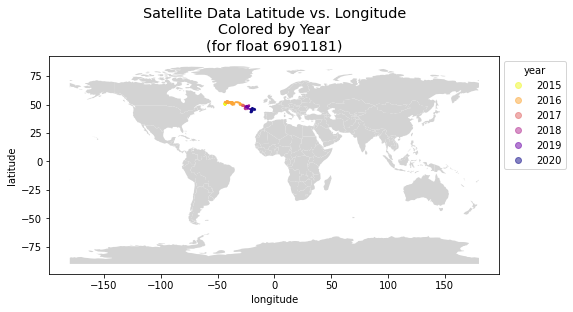

In [5]:
# visualize satellite observations matches with a certain float over the years
tmp_float = mode(sat_df['float'])
tmp_df = sat_df[sat_df['float'] == tmp_float].reset_index(drop=True)
tmp_df['year'] = [d.year for d in tmp_df['date']]
plot_on_map(df=tmp_df, source='satellite', features='year', data_type='categorical', subtitle=f'for float {tmp_float}')


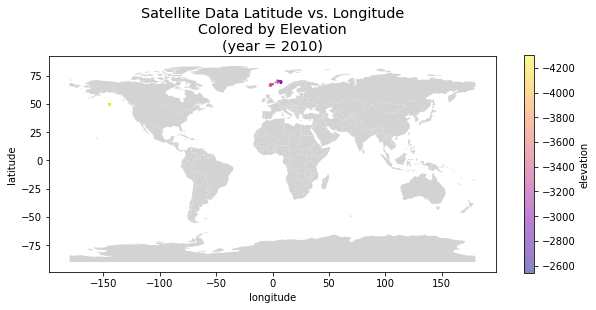

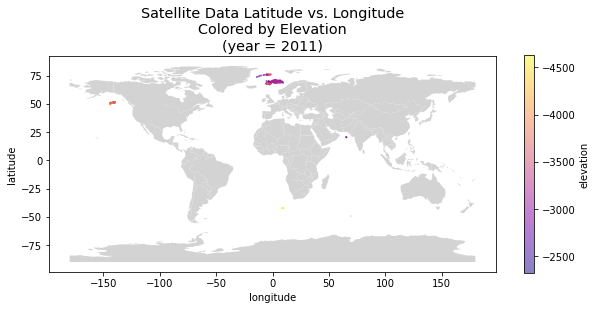

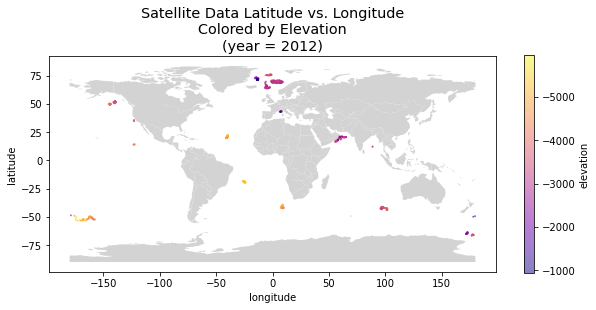

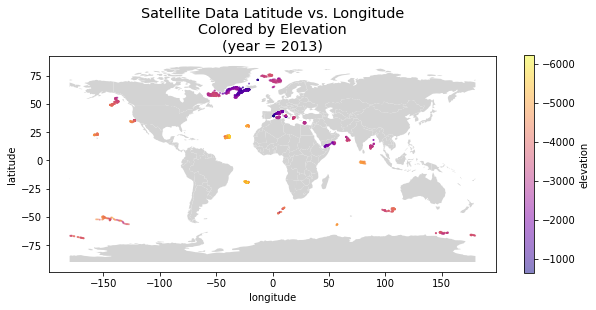

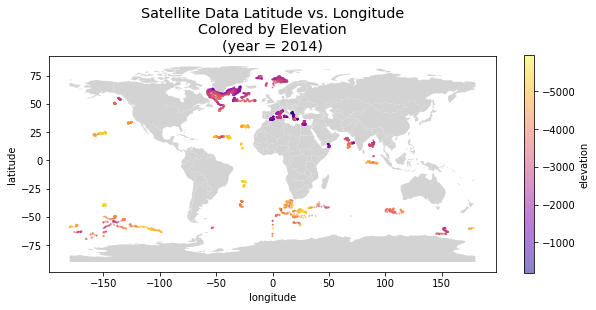

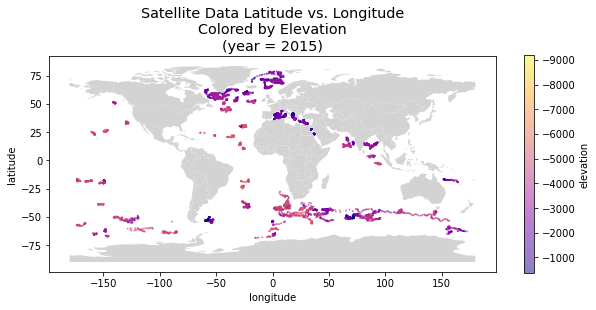

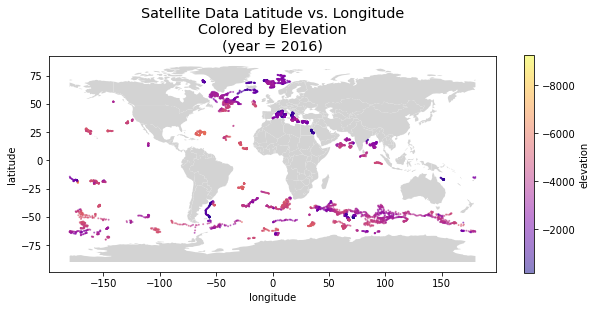

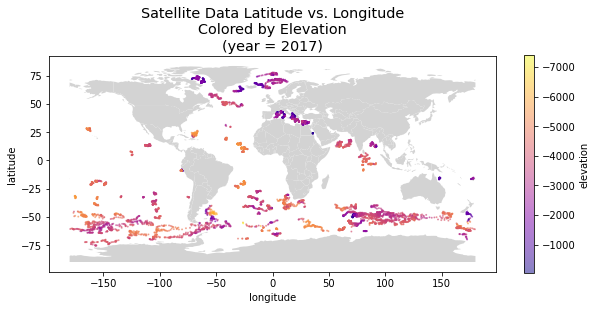

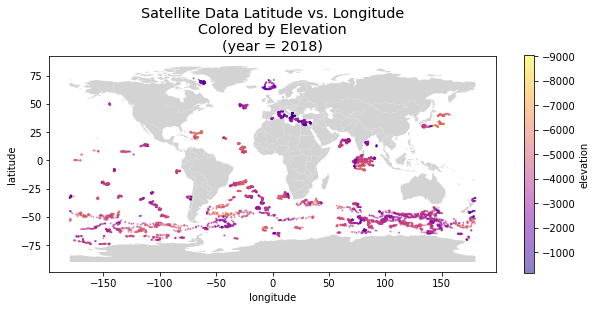

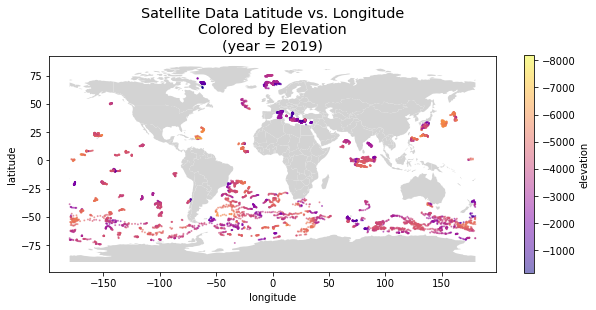

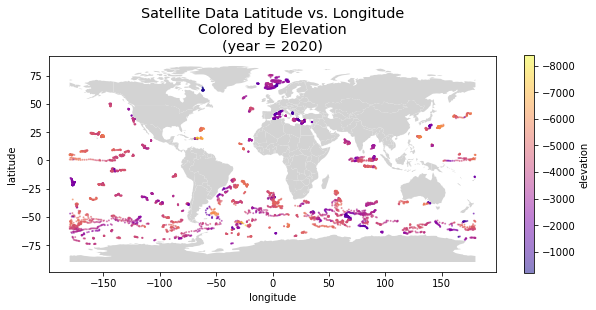

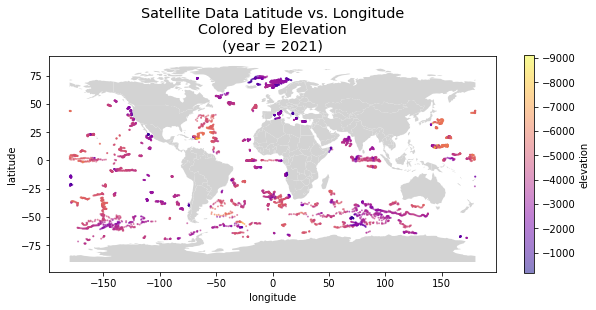

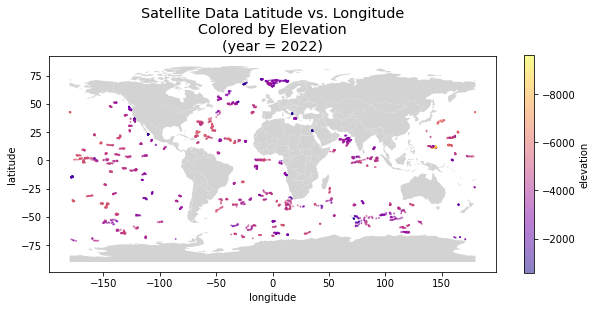

In [6]:
years = np.unique([d.year for d in sat_df['date']])
for y in years:
    tmp_df = sat_df[(sat_df['date'] >= datetime(y, 1, 1)) & (sat_df['date'] < datetime(y+1, 1, 1))]
    plot_on_map(df=tmp_df, source='satellite', features='elevation', data_type='continuous', subtitle=f'year = {y}')
    

### globalFloatData.csv

In [7]:
# load float location data;
# linking floats to lat and long by date
loc_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
loc_data_file = 'globalFloatData.csv'
loc_df = pd.read_csv(loc_data_path + loc_data_file)

# add date column as datetime
loc_df.rename({'date': 'date_str'}, axis=1, inplace=True)
loc_df.insert(loc=list(loc_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in loc_df['date_str']])

# view shape and missing value information
print(f'shape: {loc_df.shape}\n')
print(f'missing values:\n---------------\n{loc_df.isna().sum()}\n')
print(f'number of unique floats: {len(np.unique(loc_df["float"]))}\n')

loc_df


shape: (103171, 5)

missing values:
---------------
float        0
date         0
date_str     0
latitude     0
longitude    0
dtype: int64

number of unique floats: 716



,float,date,date_str,latitude,longitude
0,1902303,2021-05-06 02:03:16,2021-05-06 02:03:16,49.236,-14.742
1,1902303,2021-05-06 19:32:57,2021-05-06 19:32:57,49.096,-14.617
2,1902303,2021-05-07 20:05:38,2021-05-07 20:05:38,48.914,-14.606
3,1902303,2021-05-08 22:42:52,2021-05-08 22:42:52,48.794,-14.689
4,1902303,2021-05-09 20:29:00,2021-05-09 20:29:00,48.719,-14.795
...,...,...,...,...,...
103166,2903700,2022-08-28 11:36:48,2022-08-28 11:36:48,45.717,158.026
103167,2903700,2022-08-29 13:07:18,2022-08-29 13:07:18,45.717,157.993
103168,2903700,2022-08-30 11:45:43,2022-08-30 11:45:43,45.725,157.968
103169,5905229,2018-12-12 01:31:03,2018-12-12 01:31:03,-14.924,108.402


### profileData.csv

In [8]:
float_loc_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'     # same as float_data_path
float_loc_data_file = 'floatLocData.csv'

try:
    # read saved joined dataframe
    date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    float_loc_df = pd.read_csv(float_loc_data_path + float_loc_data_file, parse_dates=['date'], date_parser=date_parser)     #.drop(columns='date')
#     float_loc_df.insert(loc=list(float_loc_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in float_loc_df['date_str']])
    
except FileNotFoundError:  
    # proceed with preliminary float-satellite merging process
    print('Joining profile data on global float data...')
    start_time = time()
    
    # load float profile data
    float_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
    float_data_file = 'profileData.csv'
    float_df = pd.read_csv(float_data_path + float_data_file)

    # add date column as datetime
    float_df.rename({'date': 'date_str'}, axis=1, inplace=True)
    float_df.insert(loc=list(float_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in float_df['date_str']])

    # join float profile data on location
    float_loc_df = pd.DataFrame(columns=list(float_df.columns)[:1] + ['latitude', 'longitude'] + list(float_df.columns)[1:])
    for f in np.unique(float_df['float']):
        tmp_float_df = float_df[float_df['float'] == f]
        tmp_loc_df = loc_df[loc_df['float'] == f]
        tmp_df = tmp_loc_df.join(other=tmp_float_df.set_index('date'), on='date', how='inner', rsuffix='_copy')
        for c in tmp_df.columns:
            if c.endswith('_copy'):
                tmp_df.drop(columns=c, inplace=True)
        try:
            float_loc_df = pd.concat([float_loc_df, tmp_df])
        except:
            print(f'error with feature {f}')

    float_loc_df = float_loc_df.reset_index(drop=True)
    
    # confirm that the satellite and float data files contain information for exactly the same floats
    print(f"satellite and float data file contain information for exactly the same floats: {np.array_equal(np.unique(float_df['float']), np.unique(sat_df['float']))}")

    # save joined table locally
    print(f'Saving joined table to {float_loc_data_path + float_loc_data_file}...')
    float_loc_df.to_csv(float_loc_data_path + float_loc_data_file, index=False, date_format='%Y-%m-%d %H:%M:%S')
    print(f'Done -- time taken = {time() - start_time:.4f}s')

# either way, display dataframe information and data
print(f'shape: {float_loc_df.shape}\n')

print(f'missing values:\n---------------\n{float_loc_df.isna().sum()}\n')

print(f'number of unique floats: {len(np.unique(float_loc_df["float"]))}\n')

float_loc_df


shape: (33210617, 11)

missing values:
---------------
float               0
latitude            0
longitude           0
cycleNumber         0
date                0
date_str            0
PRES                0
PSAL           839242
TEMP             9603
BBP700         152057
CHLA           133621
dtype: int64

number of unique floats: 565



,float,latitude,longitude,cycleNumber,date,date_str,PRES,PSAL,TEMP,BBP700,CHLA
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,6.958747e-01
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,6.958747e-01
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,6.964993e-01
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,7.164887e-01
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...
33210612,7901001,17.330,-23.271,28,2022-05-23 11:34:00,2022-05-23 11:34:00,968,34.916109,6.358057,0.000216,-3.686869e-05
33210613,7901001,17.330,-23.271,28,2022-05-23 11:34:00,2022-05-23 11:34:00,975,34.916280,6.346782,0.000216,-1.843434e-05
33210614,7901001,17.330,-23.271,28,2022-05-23 11:34:00,2022-05-23 11:34:00,977,34.916280,6.346782,0.000216,2.543358e-18
33210615,7901001,17.330,-23.271,28,2022-05-23 11:34:00,2022-05-23 11:34:00,982,34.916280,6.346782,0.000216,2.543358e-18


In [9]:
# floats no longer included after join
missing_floats = set(np.unique(sat_df['float'])) - set(np.unique(float_loc_df['float']))
missing_floats


{4902602, 6900877, 6903125, 6903127}

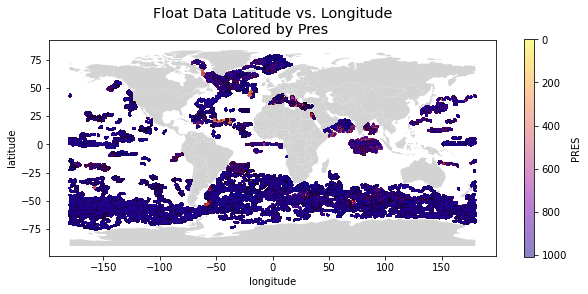

In [10]:
# visualize resulting float observations on map
# makes apparent the undersampling or unsampling of several ocean regions
plot_on_map(df=float_loc_df, source='float', features='PRES', data_type='continuous')


### float data map

In [11]:
years = np.unique([d.year for d in sat_df['date']])

seasons = ['spring', 'summer', 'fall', 'winter']
season_dfs = [pd.DataFrame(columns=float_loc_df.columns) for s in seasons]

for y in years:
    tmp_df = float_loc_df[(float_loc_df['date'] >= datetime(y, 1, 1)) & (float_loc_df['date'] < datetime(y+1, 1, 1))]
    season_starts = [datetime(y, 3, 21), datetime(y, 6, 21), datetime(y, 9, 22), datetime(y, 12, 21)]
    # spring through fall
    for i in range(len(seasons)-1):
        season_dfs[i] = pd.concat([season_dfs[i], tmp_df[(tmp_df['date'] >= season_starts[i]) & (tmp_df['date'] < season_starts[i+1])]]).reset_index(drop=True)
    # winter
    season_dfs[3] = pd.concat([season_dfs[3], tmp_df[(tmp_df['date'] >= season_starts[3]) | (tmp_df['date'] < season_starts[0])]]).reset_index(drop=True)


season = spring...
season = summer...
season = fall...
season = winter...


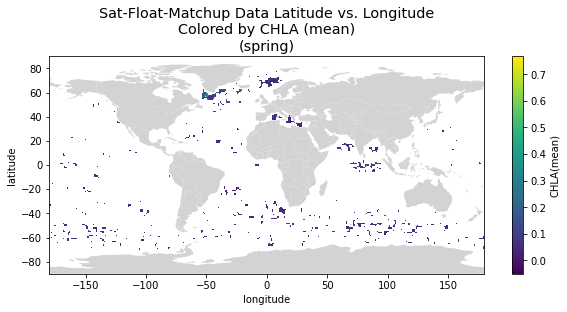

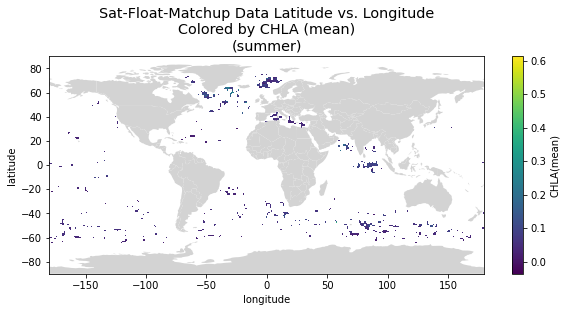

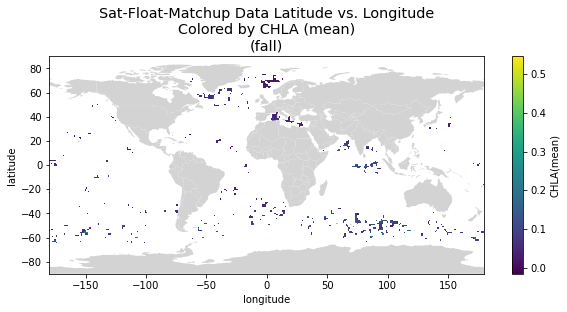

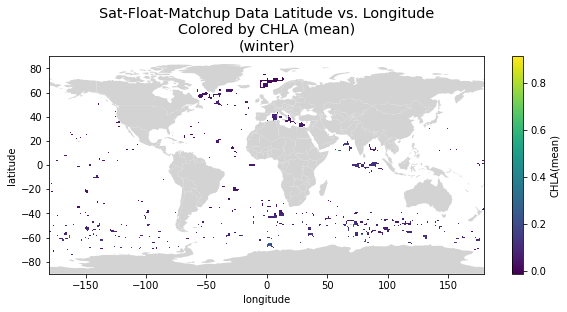

In [12]:
# plot mean CHLA in each location
for i in range(len(seasons)):
    print(f'season = {seasons[i]}...')
    plot_loc_heatmap(df=season_dfs[i], source='sat-float-matchup', agg_funct='mean', features='CHLA', subtitle=seasons[i])
    

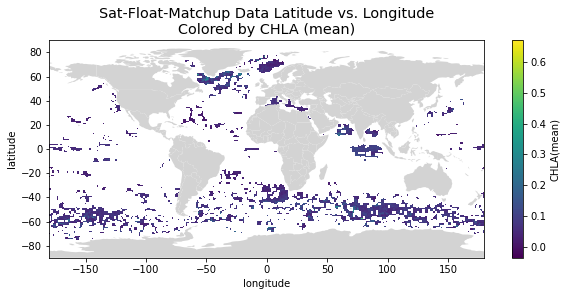

In [13]:
plot_loc_heatmap(df=float_loc_df, source='sat-float-matchup', agg_funct='mean', features='CHLA')


season = spring...
season = summer...
season = fall...
season = winter...


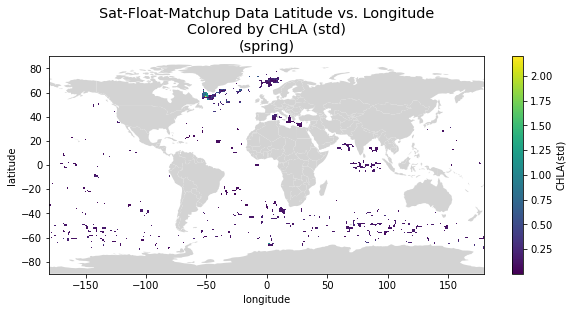

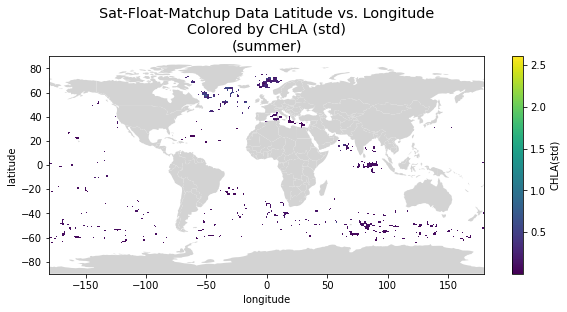

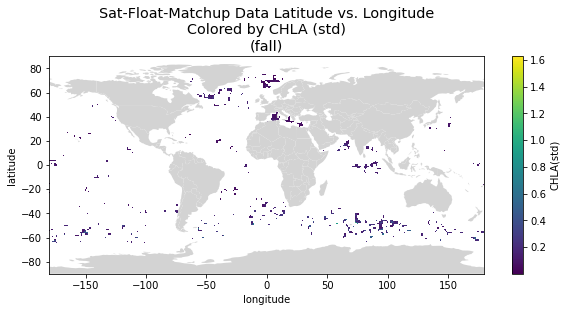

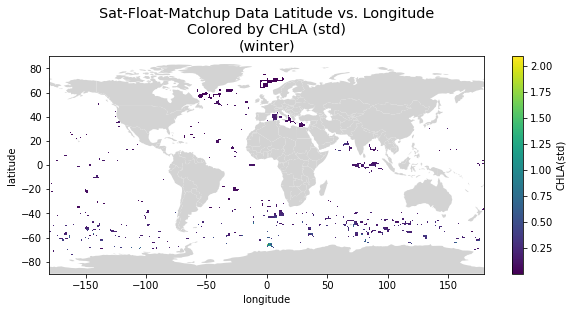

In [14]:
# plot std of CHLA in each location
for i in range(len(seasons)):
    print(f'season = {seasons[i]}...')
    plot_loc_heatmap(df=season_dfs[i], source='sat-float-matchup', agg_funct='std', features='CHLA', subtitle=seasons[i])     #, figsize=(20,8))
    

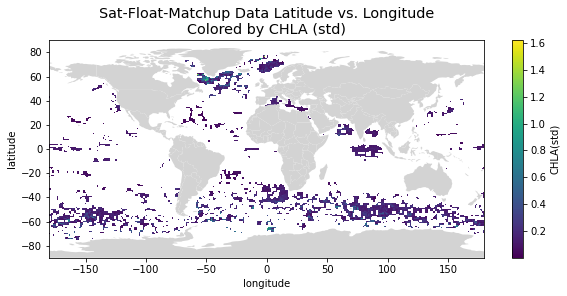

In [15]:
plot_loc_heatmap(df=float_loc_df, source='sat-float-matchup', agg_funct='std', features='CHLA')


season = spring...
season = summer...
season = fall...
season = winter...


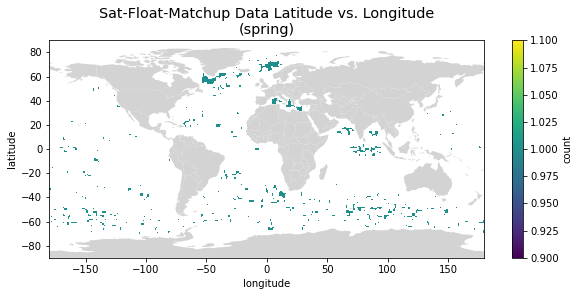

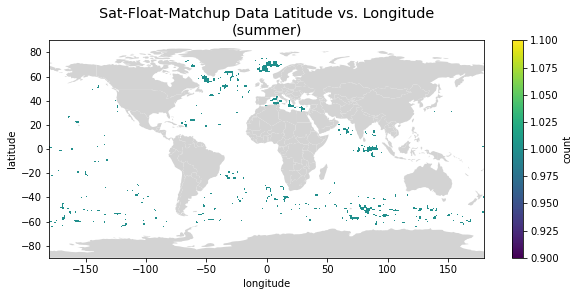

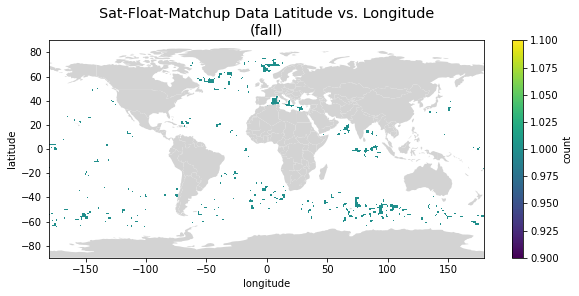

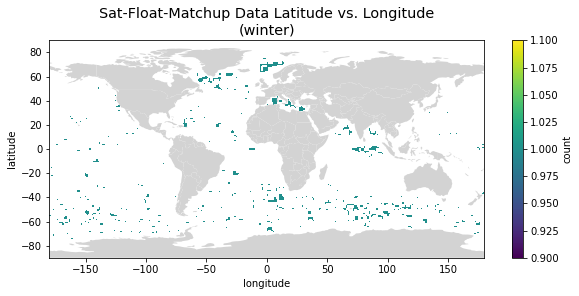

In [16]:
# plot the observations by season, unadjusted for hemisphere 
for i in range(len(seasons)):
    print(f'season = {seasons[i]}...')
    plot_loc_heatmap(df=season_dfs[i], source='sat-float-matchup', agg_funct='count', subtitle=seasons[i])     #, figsize=(20,8))
    

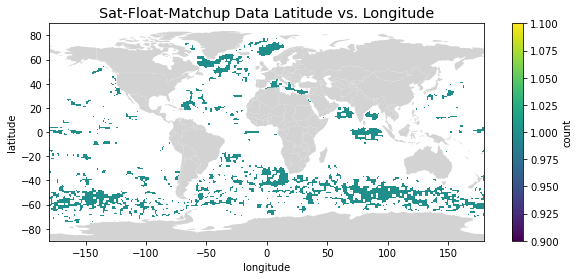

In [17]:
plot_loc_heatmap(df=float_loc_df, source='sat-float-matchup', agg_funct='count')


In [18]:
for i in range(len(seasons)):
    print(f'Shape {seasons[i]} df: {season_dfs[i].shape}')
    

Shape spring df: (8933716, 11)
Shape summer df: (7290864, 11)
Shape fall df: (7984929, 11)
Shape winter df: (9001108, 11)


### missing value analysis

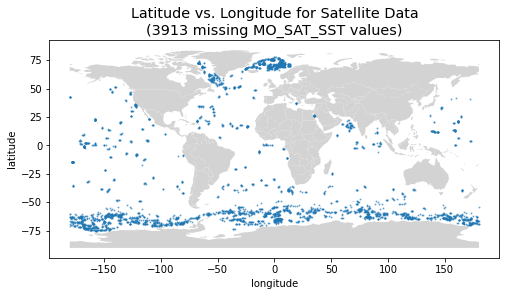

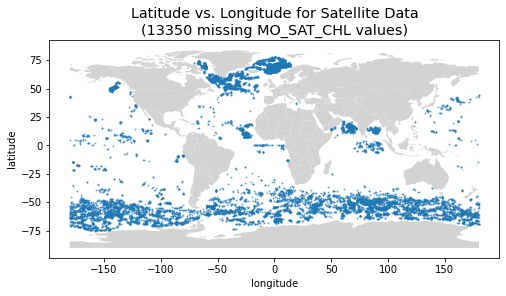

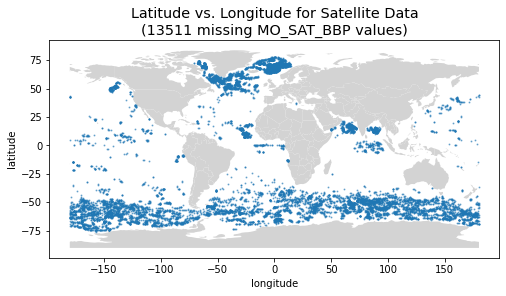

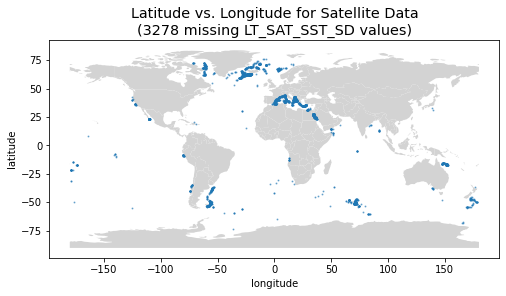

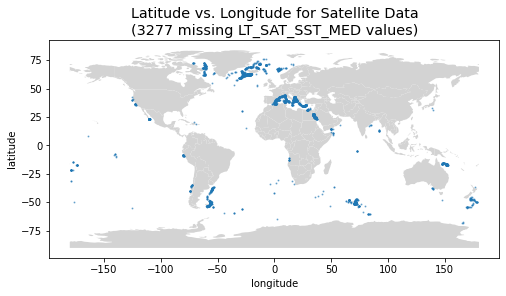

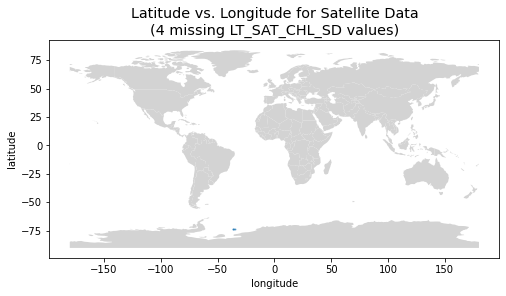

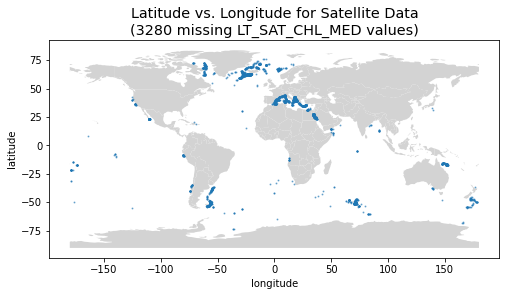

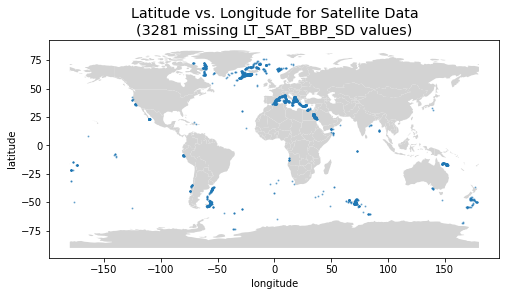

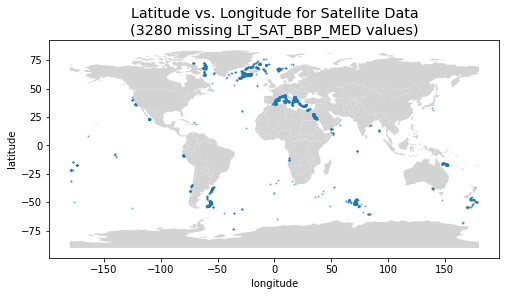

In [19]:
# plot floats with missing values by variable
feats_with_missing = {key:val for key,val in sat_df.isna().sum().to_dict().items() if val>0}.keys()

for feat in feats_with_missing:
    tmp_df = sat_df[sat_df[feat].isna()]
    plot_on_map(df=tmp_df, source='satellite', subtitle=f'{tmp_df.shape[0]} missing {feat} values')
    
# note: these are preliminary plots to test the functionality of the plotting function for mossing value purposes
# more insightful plots can be made by faceting by season, feature, etc.

### float instances by season

In [20]:
# add a feature for season
# note: this will be adjusted for hemisphere in future analysis
seasons = ['spring', 'summer', 'fall', 'winter']
seasons_col = []
for i in range(float_loc_df.shape[0]):
    d = float_loc_df.loc[i,'date']
    season_starts = [datetime(d.year, 3, 21), datetime(d.year, 6, 21), datetime(d.year, 9, 22), datetime(d.year, 12, 21)]
    
    # spring through fall
    for j in range(len(seasons)-1):
        if d >= season_starts[j] and d < season_starts[j+1]:
            seasons_col.append(seasons[j])
     
    # winter
    if d >= season_starts[3] or d < season_starts[0]:
        seasons_col.append(seasons[3])

float_loc_df.insert(loc=list(float_loc_df.columns).index('date_str')+1, column='season', value=seasons_col)
float_loc_df


,float,latitude,longitude,cycleNumber,date,date_str,season,PRES,PSAL,TEMP,BBP700,CHLA
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2021-05-06 02:03:16,spring,3,35.539001,12.378333,0.001788,6.958747e-01
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2021-05-06 02:03:16,spring,4,35.539001,12.378333,0.001788,6.958747e-01
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2021-05-06 02:03:16,spring,6,35.539001,12.378667,0.001788,6.964993e-01
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2021-05-06 02:03:16,spring,8,35.539001,12.379000,0.001789,7.164887e-01
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,2021-05-06 02:03:16,spring,10,35.539001,12.379000,0.001790,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
33210612,7901001,17.330,-23.271,28,2022-05-23 11:34:00,2022-05-23 11:34:00,spring,968,34.916109,6.358057,0.000216,-3.686869e-05
33210613,7901001,17.330,-23.271,28,2022-05-23 11:34:00,2022-05-23 11:34:00,spring,975,34.916280,6.346782,0.000216,-1.843434e-05
33210614,7901001,17.330,-23.271,28,2022-05-23 11:34:00,2022-05-23 11:34:00,spring,977,34.916280,6.346782,0.000216,2.543358e-18
33210615,7901001,17.330,-23.271,28,2022-05-23 11:34:00,2022-05-23 11:34:00,spring,982,34.916280,6.346782,0.000216,2.543358e-18


In [21]:
for s in seasons:
    print(f'Number of {s} observations: {float_loc_df[float_loc_df["season"] == s].shape[0]}')
    

Number of spring observations: 8933716
Number of summer observations: 7290864
Number of fall observations: 7984929
Number of winter observations: 9001108


In [22]:
# repeat for satellite
# add a feature for season
seasons_col = []
for i in range(sat_df.shape[0]):
    d = sat_df.loc[i,'date']
    season_starts = [datetime(d.year, 3, 21), datetime(d.year, 6, 21), datetime(d.year, 9, 22), datetime(d.year, 12, 21)]
    
    # spring through fall
    for j in range(len(seasons)-1):
        if d >= season_starts[j] and d < season_starts[j+1]:
            seasons_col.append(seasons[j])
     
    # winter
    if d >= season_starts[3] or d < season_starts[0]:
        seasons_col.append(seasons[3])

sat_df.insert(loc=list(sat_df.columns).index('date_str')+1, column='season', value=seasons_col)
sat_df


,float,cycleNumber,date,date_str,season,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_SST_SD,LT_SAT_SST_MED,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED
0,1902303,1,2021-05-06 02:03:16,2021-05-06 02:03:16,spring,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340,2.156995,12.796509,0.253809,0.401662,0.000819,0.002213
1,1902303,2,2021-05-06 19:32:57,2021-05-06 19:32:57,spring,49.096000,-14.617000,-4612.0,12.466026,0.782180,0.003081,2.214400,12.673785,0.222806,0.398969,0.000793,0.002114
2,1902303,3,2021-05-07 20:05:38,2021-05-07 20:05:38,spring,48.914000,-14.606000,-4700.0,12.424099,0.458020,0.003185,2.211703,12.808284,0.279028,0.428079,0.000752,0.002105
3,1902303,4,2021-05-08 22:42:52,2021-05-08 22:42:52,spring,48.794000,-14.689000,-4753.0,12.374519,0.378064,0.001767,2.200517,13.010804,0.278832,0.422287,0.000679,0.002087
4,1902303,5,2021-05-09 20:29:00,2021-05-09 20:29:00,spring,48.719000,-14.795000,-4765.0,12.204494,0.411479,0.001677,2.232417,12.931680,0.334429,0.419105,0.000776,0.002090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66266,7901001,24,2022-05-03 11:39:00,2022-05-03 11:39:00,spring,16.952567,-23.771903,-3307.5,NaN,NaN,NaN,1.798208,23.813510,0.176508,0.168792,0.000469,0.001396
66267,7901001,25,2022-05-08 11:38:00,2022-05-08 11:38:00,spring,17.122190,-23.669913,-3403.0,NaN,NaN,NaN,1.806874,23.809406,0.132410,0.169196,0.000483,0.001323
66268,7901001,26,2022-05-13 11:38:00,2022-05-13 11:38:00,spring,17.271005,-23.510565,-3433.0,NaN,NaN,NaN,1.810848,23.670376,0.145557,0.174282,0.000498,0.001369
66269,7901001,27,2022-05-18 11:27:00,2022-05-18 11:27:00,spring,17.316058,-23.379375,-3421.5,NaN,NaN,NaN,1.859061,23.597794,0.378395,0.184432,0.000515,0.001366


In [23]:
for s in seasons:
    print(f'Number of {s} observations: {sat_df[sat_df["season"] == s].shape[0]}')
    

Number of spring observations: 17618
Number of summer observations: 15135
Number of fall observations: 15922
Number of winter observations: 17596


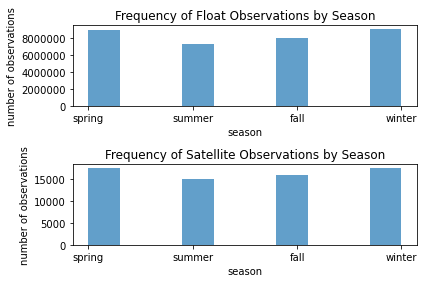

In [24]:
# plots frequency of observations by season
# shows relative balance; further analysis with adjustment by season is necessary
plt.subplot(2,1,1)
plt.hist(float_loc_df['season'], alpha=0.7)
plt.title('Frequency of Float Observations by Season')
plt.xlabel('season')
plt.ylabel('number of observations')
plt.yticks(ticks=np.arange(0, 9000000, step=2000000), labels=np.arange(0, 9000000, step=2000000))
plt.subplot(2,1,2)
plt.hist(sat_df['season'], alpha=0.7)
plt.title('Frequency of Satellite Observations by Season')
plt.xlabel('season')
plt.ylabel('number of observations')
plt.tight_layout()
plt.show()
